In [1]:
# Adapted from: https://github.com/lazyprogrammer/machine_learning_examples/tree/master/rl
# the Monte Carlo Epsilon-Greedy method to find the optimal policy and value function
import numpy as np
import matplotlib.pyplot as plt
from gridWorldGame import standard_grid, negative_grid,print_values, print_policy

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [2]:
def random_action(a, eps=0.1):
  # choose given a with probability 1 - eps + eps/4
  p = np.random.random()
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [3]:
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

In [4]:
def play_game(grid, policy):
  # returns a list of states and corresponding returns
  # use an epsilon-soft policy
  s = (2, 0)
  grid.set_state(s)
  a = random_action(policy[s])

  # each triple is s(t), a(t), r(t)
  # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
  states_actions_rewards = [(s, a, 0)]
  while True:
    r = grid.move(a)
    s = grid.current_state()
    if grid.game_over():
      states_actions_rewards.append((s, None, r))
      break
    else:
      a = random_action(policy[s]) # the next state is stochastic
      states_actions_rewards.append((s, a, r))

  # calculate the returns by working backwards from the terminal state
  G = 0
  states_actions_returns = []
  first = True
  for s, a, r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_actions_returns.append((s, a, G))
    G = r + GAMMA*G
  states_actions_returns.reverse() # we want it to be in order of state visited
  return states_actions_returns

In [5]:
grid = negative_grid(step_cost=-0.1)
# print rewards
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


In [6]:
# state -> action
# initialize a random policy
policy = {}
for s in grid.actions.keys():
  policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)
  
# initial policy
print("initial policy:")
print_policy(policy, grid)

initial policy:
---------------------------
  L  |  L  |  D  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  L  |


In [7]:
# initialize Q(s,a) and returns
Q = {}
returns = {} # dictionary of state -> list of returns we've received
states = grid.all_states()
for s in states:
  if s in grid.actions: # not a terminal state
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      Q[s][a] = 0
      returns[(s,a)] = []
  else:
    # terminal state or state we can't otherwise get to
    pass
  
# initial Q values for all states in grid
print(Q)

{(0, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (0, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (0, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0}}


In [8]:
# repeat
deltas = []
for t in range(5000):
  # generate an episode using pi
  biggest_change = 0
  states_actions_returns = play_game(grid, policy)

  # calculate Q(s,a)
  seen_state_action_pairs = set()
  for s, a, G in states_actions_returns:
    # check if we have already seen s
    # called "first-visit" MC policy evaluation
    sa = (s, a)
    if sa not in seen_state_action_pairs:
      old_q = Q[s][a]
      returns[sa].append(G)
      Q[s][a] = np.mean(returns[sa])
      biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
      seen_state_action_pairs.add(sa)
  deltas.append(biggest_change)

  # calculate new policy pi(s) = argmax[a]{ Q(s,a) }
  for s in policy.keys():
    a, _ = max_dict(Q[s])
    policy[s] = a

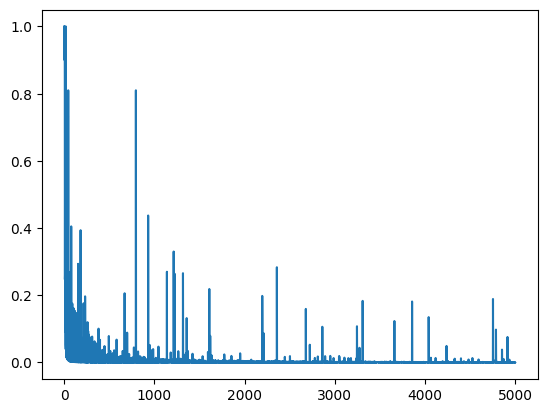

In [9]:
plt.plot(deltas)
plt.show()

In [10]:
# find the optimal state-value function
# V(s) = max[a]{ Q(s,a) }
V = {}
for s in policy.keys():
  V[s] = max_dict(Q[s])[1]

print("final values:")
print_values(V, grid)

final values:
---------------------------
 0.10| 0.77| 1.00| 0.00|
---------------------------
 0.02| 0.00| 0.77| 0.00|
---------------------------
 0.21| 0.36| 0.54| 0.32|


In [11]:
print("final policy:")
print_policy(policy, grid)

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  D  |     |  U  |     |
---------------------------
  R  |  R  |  U  |  L  |
